<a href="https://colab.research.google.com/github/acevedo-s/Machine-learning-phases-of-matter/blob/master/Model_transfer_Honeycomb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import csv
import random
import matplotlib.pyplot as plt
from google.colab import drive  
drive.mount('/content/drive')

import keras
keras.__version__
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.utils import to_categorical  
from keras.regularizers import l2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [ ]:
def loadD(name,L,datapath,labelflag,Tc,a,windowflag,r):
  print(name)
  data=[]
  with open(datapath, newline='\n') as csvfile: #read data file
    csv_reader = csv.reader(csvfile, delimiter=' ')
    for line in csv_reader:
      line.remove('') #remove this white space
      if (labelflag==0): #if not labeled, i label it.
          if (float(line[0])<Tc):
            line.insert(0,0)
          else:
            line.insert(0,1)
      data.append(line)

  if (windowflag):
    window=[] # i remove a window from data with T close to Tc
    for x in data[:]:
      if (abs(Tc-float(x[1]))<a): # T=data[k][1]
        window.append(x)
        data.remove(x)
  #now data only has data far from Tc
  #r=0.8 ;
  l=int(r*len(data))
  train_data=data[:l]  #i partition here the hole data set between train data and test data.
  random.shuffle(train_data)
  test_data=data[l:len(data)]
  if (windowflag):
    test_data=test_data+window
  del(data)

  train_labels,train_temperatures,train_data=get_format(train_data,L) #(validation data will be a fraction of the train data)
  test_labels,test_temperatures,test_data=get_format(test_data,L)

  print('lenght of train data: ', len(train_data))
  print('lenght of test data: ', len(test_data))

  checkflag=1
  if windowflag:
    if checkflag:
      c=0
      for T in train_temperatures: # to see if some forbidden temperature is still in the training set.
        if(abs(T-Tc)<a):
          c+=1
      print('checkflag:',c)
  return [train_data,train_labels,test_data,test_labels,test_temperatures]
###################-----------------
def get_format(data,L):
  labels=[]
  temperatures=[]
  for element in data:
    label=element.pop(0) # remove the first element, the label
    labels.append(label) # add to label list
    TT=element.pop(0)  # remove the second element, the temperature
    temperatures.append(TT) # add to temperature list
  #numpy arrays of strings, and string to integers
  data=np.array(data)
  #print(np.shape(data))
  data=data.reshape(len(data),L,L) #string to matrix
  data = data.astype(np.float)
  data=(data+1.)/2 # normalization
  labels=np.array(labels)
  labels=labels.astype(np.int)
  temperatures=np.array(temperatures)
  temperatures=temperatures.astype(np.float)
  return labels,temperatures,data
#######################---------------------------

def ProbabilityPredictions(model,test_data,test_temperatures):
  test_predictions=model.predict(test_data)
  prob_T=[]
  for j in range(len(test_temperatures)):
    prob_T.append([test_temperatures[j],test_predictions[j]])
  #print(prob_T[0])
  prob_T=sorted(prob_T,key=lambda x: x[0]) # ordered by temperatures 
  #len(prob_T)

  #prob_TNP=np.array([])
  j=0
  epsilon=0.001
  j_max=len(prob_T)

  while(j+1 < j_max-1): # for the same temperatures i average the results
    count=1
    while(j+1 < j_max and abs(prob_T[j][0]-prob_T[j+1][0])<epsilon):
      count=count+1
      x=prob_T.pop(j+1)
      prob_T[j][1]=prob_T[j][1]+x[1]
      j_max=len(prob_T)
    prob_T[j][1]=prob_T[j][1]/float(count)
    j=j+1
    j_max=len(prob_T)
  
  print('number of temperatures: ',len(prob_T))
  T_list=[];p1_list=[];p2_list=[];check_list=[]
  for j in range(len(prob_T)):
    T_list.append(prob_T[j][0])
    p1_list.append(prob_T[j][1][0])
    p2_list.append(prob_T[j][1][1])
    #check_list.append(prob_T[j][1][1] +prob_T[j][1][0] )
  return [T_list,p1_list,p2_list]

########################----------
########################----------------------------------------

#for fancy plotting
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'figure.autolayout': True})


In [ ]:
def makedicy(name,L,J2,path,label,Tc,loadflag,categoricalflag,r):
  mydict={'name': name,'L':L,'J2':J2,'path':path,'label':label,'Tc':Tc\
          ,'loadflag':loadflag,'categoricalflag':categoricalflag,'train_ratio':r}
  return mydict

Dicyslist=[];
L=30
Nfiles=0
# r is de train_data ratio from total data.

J2list=[0.0,0.05,0.10,0.15,0.20,0.23,0.25]
Tclist=[1.519,1.25,0.98,0.69,0.41,0.32,0]
r=0.8
for k in range(len(J2list)):
  name='Honeycombe '+str(J2list[k])
  path='drive/My Drive/Machine Learning magnetism/paper2020/data_honey_AF/900/arrays_'+str(L)+ \
  '_-'+str("{:.2f}".format(J2list[k]))+'.txt'
  x=makedicy(name,L,J2list[k],path,0,Tclist[k],1,1,r)
  Dicyslist.append(x)
  Nfiles+=1
  r=0.2

print('number of files:',Nfiles)
for k in range(Nfiles):
  Dicyslist[k]['channelflag']=1


number of files: 7


In [ ]:
#adding data to diccionary  
#'data' format is as follows: 
# train_data,train_labels,test_data,test_labels,test_temperatures
a=0.3 # parameter to exclude transition data from training
windowflag=1
for k in range(Nfiles): # this takes a while
  if(Dicyslist[k]['loadflag']):
    Dicyslist[k]['data']=loadD(Dicyslist[k]['name'],Dicyslist[k]['L'],Dicyslist[k]['path'] \
                            ,Dicyslist[k]['label'],Dicyslist[k]['Tc'],a,windowflag,Dicyslist[k]['train_ratio'])
    #windowflag=0 # i only train with honey 
    Dicyslist[k]['loadflag']=0 

Honeycombe 0.0
lenght of train data:  55360
lenght of test data:  24640
checkflag: 0
Honeycombe 0.05
lenght of train data:  13840
lenght of test data:  66160
checkflag: 0
Honeycombe 0.1
lenght of train data:  13920
lenght of test data:  66080
checkflag: 0
Honeycombe 0.15
lenght of train data:  13920
lenght of test data:  66080
checkflag: 0
Honeycombe 0.2
lenght of train data:  13840
lenght of test data:  66160
checkflag: 0
Honeycombe 0.23
lenght of train data:  13840
lenght of test data:  66160
checkflag: 0
Honeycombe 0.25
lenght of train data:  14960
lenght of test data:  65040
checkflag: 0


###Training

In [ ]:
# Keras label formatting
for k in range(Nfiles):
  if (Dicyslist[k]['categoricalflag']):
    Dicyslist[k]['data'][1] = to_categorical(Dicyslist[k]['data'][1])
    Dicyslist[k]['data'][3] = to_categorical(Dicyslist[k]['data'][3])
    Dicyslist[k]['categoricalflag']=0; # because this must be done only one time.
  if (Dicyslist[k]['channelflag']):
     Dicyslist[k]['data'][0]=Dicyslist[k]['data'][0][..., np.newaxis] # 1 channel for CNNs 
     Dicyslist[k]['data'][2]=Dicyslist[k]['data'][2][..., np.newaxis]
     Dicyslist[k]['channelflag']=0

In [ ]:
def train(Dicyslist,FN,Ndense,Bsize,epochs_val,k):
  L=30
  damn=optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, amsgrad=False)
  model = models.Sequential()
  FS=3 #FiltreSize  3 is standard
  model.add(layers.Conv2D(FN, (FS, FS), activation='relu', input_shape=(L, L, 1)))
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Conv2D(FN, (FS, FS), activation='relu', input_shape=(L, L, 1)))
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(Ndense, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  VS=0.1 #validation split
  model.compile(optimizer=damn,
  loss='categorical_crossentropy',
  metrics=['accuracy'])
  history=model.fit(Dicyslist[k]['data'][0], Dicyslist[k]['data'][1], validation_split=VS,
            shuffle=True, epochs=epochs_val, batch_size=Bsize)
  history_dict = history.history
  return model,history.history

### Transfers

In [ ]:
def predictions_t(predictionflag,Dicyslist,ktrain,FN,Ndense,Bsize,epochs_val,ktransfer,test_acc_val,tlim,eps):
  acc=0;
  while(acc< test_acc_val):# training 
    trainedmodel,history_dict=train(Dicyslist,FN,Ndense,Bsize,epochs_val,ktrain)
    acc=history_dict['val_accuracy'][-1] # last acc in training
  p1_list=[];
  p2_list=[];
  T_list,x,y=ProbabilityPredictions(trainedmodel,Dicyslist[ktransfer]['data'][2],Dicyslist[ktransfer]['data'][4])
  p1_list.append(x)
  p2_list.append(y)
  p2_list=np.array(p2_list)
  
  t=min(abs(p2_list[0]-.5))
  print('t=',t)
  if(t< tlim and (max(p2_list[0])-min(p2_list[0]))> eps):
    predictionflag=1
  return predictionflag,trainedmodel,p1_list,p2_list

In [ ]:
### Export/Import trained model
from keras.models import load_model
import h5py
#Flags:
gustan=0
loadmodel=1

modelpath='drive/My Drive/Machine Learning magnetism/paper2020/trained_models'
modelname=modelpath+'/model_transfer_honeycombe.h5'

# if gustan:
#   trainedmodel.save(modelname)  # creates a HDF5 file 'my_model.h5'
#   #del model  # deletes the existing model

if loadmodel:
  trainedmodel = load_model(modelname)

In [ ]:
###This cell runs the training 
trainnff=0# training flag

FN=4 #Number of filters
Ndense=16 # number of neurons in the dense hidden layer
epochs_val=1
Bsize=512 #
ktrain=0 # training here
ktransfer=Nfiles-1 # transfering here 
test_acc_val=0.85 #minimum acc in validation
tlim= 0.47 # distance to probability=0.5
eps= 0.02# not constant probability output
if (trainnff):
  predictionflag=0
  count=0
  while(predictionflag==0):  
    predictionflag,trainedmodel,p1_list,p2_list= \
    predictions_t(predictionflag,Dicyslist,ktrain,FN,Ndense,Bsize,epochs_val,ktransfer,test_acc_val,tlim,eps)
    count+=1
  print('this took ',count,' tries')

Train on 49824 samples, validate on 5536 samples
Epoch 1/1
49824/49824 [==============================] - 13s 260us/step - loss: 0.2901 - accuracy: 0.9112 - val_loss: 0.0040 - val_accuracy: 1.0000
number of temperatures:  200
t= 0.44868767
this took  1  tries


In [ ]:
###predictions:
p1_list=[];
p2_list=[];
Nplot=Nfiles
for k in range(Nplot):
  T_list,x,y=ProbabilityPredictions(trainedmodel,Dicyslist[k]['data'][2],Dicyslist[k]['data'][4])
  p1_list.append(x)
  p2_list.append(y)

number of temperatures:  200
number of temperatures:  200
number of temperatures:  200
number of temperatures:  200
number of temperatures:  200
number of temperatures:  200
number of temperatures:  200


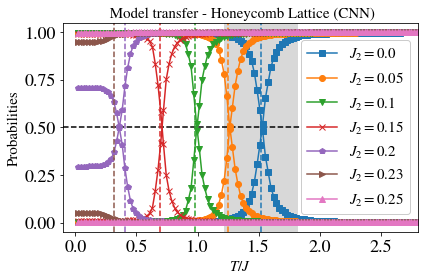

In [ ]:
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
markers=['s','o','v','x','p','>','^']
fig = plt.figure() 
ax = fig.add_subplot(111)
from google.colab import files
file_name="Model_Transfer_Honeycombe_J2_Neel.pdf"

T_list=[]
T=0.022650
dT=(4.53-T)/200
for i in range (200):
  T_list.append(T)
  T+=dT

for k in range(Nfiles):
  plt.plot(T_list, p1_list[k], label=r'$J_2=$'+ str(Dicyslist[k]['J2']), c=colors[k],marker=markers[k])#,mfc='none') #
  plt.plot(T_list, p2_list[k], c=colors[k],marker=markers[k])#,mfc='none')#, label='')
  if (k <Nfiles-1):
    plt.axvline(x=Dicyslist[k]['Tc'],c=colors[k],linestyle='--')

xmaxx=2.8
plt.title(' Model transfer - Honeycomb Lattice (CNN)',size = 15)
plt.xlabel(r'$T/J$',size = 15)
plt.ylabel('Probabilities',size = 15)
plt.legend(loc='center right',prop={'size': 15},framealpha=1)
plt.hlines(y=0.5,xmin=-0.1,xmax=0.7*xmaxx,color='black',linestyle='--')
g1=Tclist[0]-a ; g2=Tclist[0]+a
plt.axvspan(g1, g2, color='gray', alpha=0.3, lw=0) # shaded gray

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * .9, box.height])
# # Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, .8))
ax.set_xlim(-0.1,xmaxx)
#ax.set_ylim(0.499,1.005)
plt.savefig(file_name, bbox_inches="tight")
plt.show()

In [ ]:
files.download(file_name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainedmodel.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 4)         40        
_________________________________________________________________
average_pooling2d_33 (Averag (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 12, 12, 4)         148       
_________________________________________________________________
average_pooling2d_34 (Averag (None, 6, 6, 4)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 144)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                2320      
_________________________________________________________________
dense_34 (Dense)             (None, 2)               

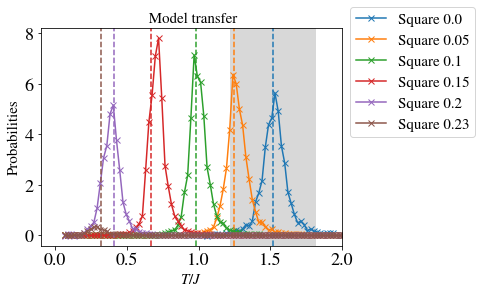

In [ ]:
def Nderiv(P_list,T_list):
  deriv=[]
  for i in range(2,len(P_list)-2):
    x=P_list[i-2]-8*P_list[i-1]+8*P_list[i+1]-P_list[i+2]
    x=x/(T_list[i+1]-T_list[i])/12
    deriv.append(x)
  return np.array(deriv)

DP_list=[]
for k in range(Nfiles):
  DP_list.append(Nderiv(p2_list[k],T_list))

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
fig = plt.figure() # crea la figura fig, sin nada, que puede tener muchas subfiguras.
ax = fig.add_subplot(111) # creo la subfigura  de 1x1 (cuadrada), numero 1. 
from google.colab import files
file_name="Model_Transfer_Honeycombe_J2_Neel_D.pdf"
T_list=[]
T=0.022650
dT=(4.53-T)/200
for i in range (200):
  T_list.append(T)
  T+=dT

for k in range(Nfiles):
  plt.plot(T_list[2:-2], DP_list[k], label=Dicyslist[k]['name'], c=colors[k],marker='x')#,mfc='none') #
  plt.axvline(x=Dicyslist[k]['Tc'],c=colors[k],linestyle='--')

plt.title(' Model transfer',size = 15)
plt.xlabel(r'$T/J$',size = 15)
plt.ylabel('Probabilities',size = 15)
#plt.legend(loc='center right',prop={'size': 15})
xmaxx=2
g1=Tclist[0]-a ; g2=Tclist[0]+a
plt.axvspan(g1, g2, color='gray', alpha=0.3, lw=0) # shaded gray
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * .9, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, .8),prop={'size': 15})
ax.set_xlim(-0.1,xmaxx)
#ax.set_ylim(0.499,1.005)
plt.savefig(file_name, bbox_inches="tight")
plt.show()





In [ ]:
files.download(file_name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>